# Generating 1-D regression figures

This notebook allows the creation of the 1-D regression figures using an existing model.

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers, optimizers

import numpy as np
import matplotlib.pyplot as plt

from collections import namedtuple

import models
import data

import seaborn as sns
sns.set()
palette = sns.color_palette()

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

randseed = 0

In [2]:
tf.random.set_seed(randseed)

num_points = 400
num_funcs = 2
num_draws = 100
num_context = [1, 10, 100]

x_values = np.linspace(-2, 2, num_points).astype("float32")[:, None]
kernel = tfp.math.psd_kernels.ExponentiatedQuadratic()

gp = tfp.distributions.GaussianProcess(kernel, x_values, jitter=1e-5)

y_values = gp.sample(num_funcs).numpy()[:, :, None]

functions = np.concatenate([np.tile(x_values, [num_funcs, 1, 1]), y_values], axis=-1)

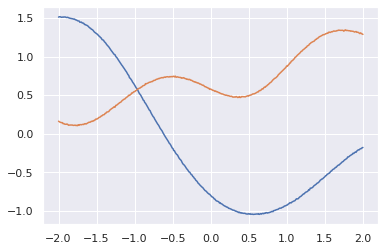

In [3]:
for i in range(num_funcs):
    plt.plot(x_values, y_values[i])

In [4]:
np.random.seed(randseed)

context_idx = np.vstack([np.random.choice(num_points, size=max(num_context), replace=False) for _ in range(num_funcs)])

context_points = np.concatenate([functions[None, i, context_idx[i]] for i in range(num_funcs)])

context_x = np.tile(np.expand_dims(context_points[:, :, 0, None], 1), [1, num_draws, 1, 1])
context_y = np.tile(np.expand_dims(context_points[:, :, 1, None], 1), [1, num_draws, 1, 1])

target_x = np.tile(x_values[None, :, :], [num_draws, 1, 1])

In [5]:
model = models.NP(128, [128, 128, 128, 128], [128, 128, 2], deterministic_encoder_sizes=None)
_ = model(context_x[0], context_y[0], target_x)
model.load_weights("weights/regression_weights.h5")

In [6]:
mus = np.zeros((len(num_context), num_funcs, num_draws, num_points, 1))

for i, n in enumerate(num_context):
    for j in range(num_funcs):
        mus[i, j], _, _, _, _ = model(context_x[j, :, :n, :], context_y[j, :, :n, :], target_x)

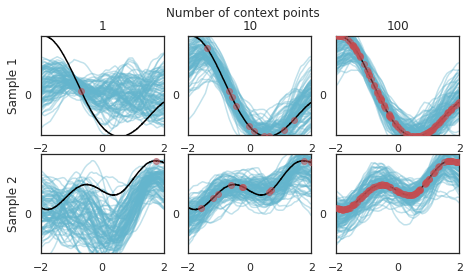

In [7]:
with sns.axes_style("white"):
    fig, axes = plt.subplots(num_funcs, len(num_context), figsize=(7.5, 4))
    #plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

fig.suptitle("Number of context points")

for ax, col in zip(axes[0], num_context):
    ax.set_title(col)
for ax, num in zip(axes[:,0], [1,2]):
    ax.set_ylabel("Sample {}".format(num))

for j, axes_ in enumerate(axes):
    for i, ax in enumerate(axes_):
        for d in range(num_draws):
            ax.plot(x_values, mus[i, j, d], color=palette[-1], zorder=1, alpha=0.4)
        
        ax.plot(x_values, y_values[j], color="black", zorder=2)
        ax.scatter(context_x[j, 0, :num_context[i]], context_y[j, 0, :num_context[i]], marker="o", color=palette[3], zorder=3, alpha=0.5)
        ax.set_xticks([-2, 0, 2])
        ax.set_yticks([0])
        ax.set_xlim([-2,2])
        ax.set_ylim([-1,1.5])

In [8]:
#fig.savefig("plots/regression_500k.png", dpi=600, bbox_inches="tight")